In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from data_creation import create_dataset
from torch_geometric.utils import dense_to_sparse

In [99]:
def to_pyg_data(x_train, y_train, ode_dim, n_data):
    # distribute x_train values as node features
    x = torch.zeros([ode_dim, 2*n_data])

    k = 0
    for j in range(0,2*n_data):
        for i in range(0,ode_dim):
            x[i,j] = x_train[k]
            k += 1

    # build edge indices (assuming fully connected network)
    adj_matrix = torch.ones((ode_dim, ode_dim))
    edge_index, _ = dense_to_sparse(adj_matrix)

    # distribute weights as edge attributes 
    edge_attr = torch.zeros([len(edge_index.t()),1])
    weights  = torch.reshape(x_train[k:],[ode_dim,ode_dim])

    k = 0
    for i in range(0,ode_dim):
        for j in range(0,ode_dim):
                edge_attr[k,0] = weights[i,j]
                k += 1

    y = y_train

    data = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

    return data

ode_dim = 2
n_data = 20
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1000)

dataset = []
for i in range(0,len(x_train)):
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [ ]:
from torch_geometric.nn.conv import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear, Sequential, ReLU
from torchdiffeq import odeint

class EdgeNet(torch.nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,edge_attr_dim):
        super(EdgeNet, self).__init__()

        self.conv_out = int(in_channels)

        self.conv_out2 = int(in_channels/2)

        print(self.conv_out2)

        self.conv_out3 = 4

        #self.conv_out4 = 2
        
        self.edge_mlp = Sequential(
            Linear(4 * in_channels + edge_attr_dim, hidden_channels),
            ReLU(),
            Linear(hidden_channels, edge_attr_dim)
        )

        self.edge_mlp2 = Sequential(
            Linear(2 * self.conv_out4 + edge_attr_dim, hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            ReLU(),
            Linear(hidden_channels, edge_attr_dim)
        )

        self.conv = GCNConv(2*in_channels,self.conv_out)

        self.conv2 = GCNConv(self.conv_out,self.conv_out)

        self.gat_conv = GATConv(2*in_channels,self.conv_out)

        self.gat_conv2 = GATConv(self.conv_out,self.conv_out2)

        self.gat_conv3 = GATConv(self.conv_out2,self.conv_out3)

        self.gat_conv4 = GATConv(self.conv_out3,self.conv_out4)

        
    
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # print(x.shape)

        # x = self.conv(x,edge_index = edge_index, edge_weight = edge_attr.abs())

        # x = self.conv2(x,edge_index = edge_index)

        # edge_attr = self.update_attributes(x,edge_index,edge_attr, self.edge_mlp)

        x = self.gat_conv(x,edge_index = edge_index)

        x = self.gat_conv2(x,edge_index = edge_index)

        x = self.gat_conv3(x,edge_index = edge_index)
        #print(edge_attr.shape)

        edge_attr = edge_attr + self.update_attributes(x,edge_index,edge_attr, self.edge_mlp2)
        # edge_attr = odeint(lambda t, edge_attr : self.rhs(t,edge_attr,edge_index,x,self.edge_mlp),edge_attr,torch.tensor([0., 1.]))[-1]
        
        #print(edge_attr.shape)
        return edge_attr
    
    def rhs(self, t, edge_attr, edge_index, x, mlp):
        row, col = edge_index
        src, tgt = x[row], x[col]

        # Concatenate node features with edge attributes
        edge_features = torch.cat([src, tgt, edge_attr], dim=-1)
            
        # Update edge attributes using an MLP
        edge_attr = mlp(edge_features)
        
        return edge_attr
    
    def update_attributes(self, x, edge_index, edge_attr, mlp):

        row, col = edge_index
        src, tgt = x[row], x[col]

        # Concatenate node features with edge attributes
        edge_features = torch.cat([src, tgt, edge_attr], dim=-1)

        # Update edge attributes using an MLP
        edge_attr = mlp(edge_features)
        
        return edge_attr

In [106]:
from torch.optim import Adam

model = EdgeNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            print(loss.item())
            test_loss.append(loss)

10
0.5043397545814514
0.49514633417129517
0.4850669205188751
0.4930919110774994
0.4779813289642334
0.46526163816452026
0.4560008943080902
0.4546869397163391
0.44713395833969116
0.4424039423465729
0.4379814863204956
0.4375828504562378
0.4308011829853058
0.4244317412376404
0.4240933358669281
0.4180907607078552
0.41583728790283203
0.4125400185585022
0.4102272689342499
0.4158271849155426
0.4097064435482025
0.40761077404022217
0.4122357666492462
0.40706121921539307
0.4063313603401184
0.405171662569046
0.40580520033836365
0.4069751799106598
0.40514427423477173
0.4036564826965332
0.4085884392261505
0.40507256984710693
0.40495187044143677
0.40323272347450256
0.40680474042892456
0.40376049280166626
0.4073407053947449
0.40924254059791565
0.4061199128627777
0.40439143776893616
0.4029896855354309
0.4035281836986542
0.40314075350761414
0.40771231055259705
0.40519171953201294
0.4030054211616516
0.4086388349533081
0.40500107407569885
0.40292882919311523
0.40459200739860535
0.40307727456092834
0.40297

KeyboardInterrupt: 

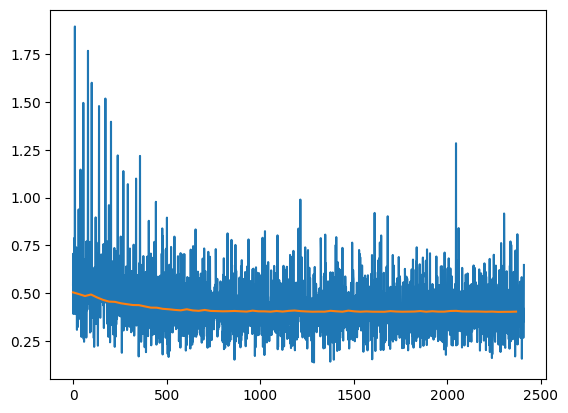

0.251
0.132
0.72425
0.47675


In [107]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    Ainit = get_adjacency(y_val[k])

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)